In [1]:
import pandas as pd

# Read the CSV file
df = pd.read_csv('Data/Clean/Orov_clean.csv')
columns_to_analyze = ['Date','T', 'V', 'P', 'F']
df = df[columns_to_analyze]
df

,Date,T,V,P,F
0,10/1/1921,50.711506,9.680717,1.173617,81.200
1,11/1/1921,42.727805,6.427311,2.666764,100.000
2,12/1/1921,36.407265,3.427978,10.194451,194.000
3,1/1/1922,32.000000,2.775463,2.969249,192.000
4,2/1/1922,32.000000,2.077533,14.370800,422.000
...,...,...,...,...,...
1195,5/1/2021,54.776440,11.438191,0.265424,136.858
1196,6/1/2021,66.966054,19.161114,0.136572,88.619
1197,7/1/2021,73.537018,24.017705,0.086182,70.112
1198,8/1/2021,70.023603,21.625689,0.024613,56.391


In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.activations import relu
import joblib
import matplotlib.pyplot as plt

# Initial random seed setting
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# Hyperparameters
alpha = 0.1  # Smoothness penalty coefficient
beta = 0.1   # Monthly weight coefficient
epochs = 5000  # Training epochs (increased from 2000 to 5000)
input_window = 12
output_window = 9
n_features = 4  # PC1 to PC4
batch_size = 32

# Define LSTM architectures
lstm_architectures = [
    [64, 32, 16],  # Original architecture
    [32, 16, 8],   # Simpler 3-layer
    [16, 8, 4],    # Simpler 3-layer
    [8, 4, 2],     # Simpler 3-layer
    [32, 16],      # 2-layer
    [16, 8],       # 2-layer
    [8, 4],        # 2-layer
    [4, 2]         # 2-layer
]

# Custom loss function
def create_custom_flow_loss(alpha, beta):
    def custom_flow_loss(y_true, y_pred):
        month_weights = tf.constant([2, 2, 2, 1.5, 1.5, 1, 1, 1, 1], dtype=tf.float32)
        mse_loss = tf.keras.losses.MSE(y_true, y_pred)
        
        # Smoothness penalty
        smoothness_penalty = tf.reduce_mean(tf.square(y_pred[:, 1:] - y_pred[:, :-1]))
        
        # Monthly weighted loss
        monthly_weight_loss = tf.reduce_mean(month_weights * tf.square(y_true - y_pred))
        
        return mse_loss + alpha * smoothness_penalty + beta * monthly_weight_loss
    return custom_flow_loss

class DataPreprocessor:
    def __init__(self):
        self.scaler = StandardScaler()
        self.pca = PCA(n_components=4)
        
    def fit_transform(self, df):
        features = df[['T', 'V', 'P', 'F']].values
        features_scaled = self.scaler.fit_transform(features)
        pca_features = self.pca.fit_transform(features_scaled)
        return pca_features
    
    def transform(self, df):
        features = df[['T', 'V', 'P', 'F']].values
        features_scaled = self.scaler.transform(features)
        pca_features = self.pca.transform(features_scaled)
        return pca_features
    
    def save(self, filename):
        preprocessor_dict = {
            'scaler': self.scaler,
            'pca': self.pca
        }
        joblib.dump(preprocessor_dict, filename)
    
    @classmethod
    def load(cls, filename):
        preprocessor = cls()
        loaded_dict = joblib.load(filename)
        preprocessor.scaler = loaded_dict['scaler']
        preprocessor.pca = loaded_dict['pca']
        return preprocessor

def prepare_sequences(features, target):
    X, y = [], []
    for i in range(len(features) - input_window - output_window + 1):
        X.append(features[i:(i + input_window)])
        y.append(target[i + input_window:i + input_window + output_window])
    return np.array(X), np.array(y)

def build_model(architecture):
    # Ensure clean state for model creation
    model = Sequential()
    
    # First LSTM layer
    model.add(LSTM(architecture[0], activation='relu', return_sequences=True if len(architecture) > 1 else False,
                  input_shape=(input_window, n_features)))
    
    # Middle LSTM layers
    for i in range(1, len(architecture) - 1):
        model.add(LSTM(architecture[i], activation='relu', return_sequences=True))
    
    # Last LSTM layer
    if len(architecture) > 1:
        model.add(LSTM(architecture[-1], activation='relu'))
    
    # Output layer
    model.add(Dense(output_window, activation='relu'))
    
    custom_loss = create_custom_flow_loss(alpha, beta)
    model.compile(optimizer='adam', loss=custom_loss)
    return model

def plot_combined_losses(all_histories, save_path='combined_losses_1943_2021.png'):
    plt.figure(figsize=(15, 8))
    
    # Create a color map for different architectures
    colors = plt.cm.rainbow(np.linspace(0, 1, len(all_histories)))
    
    for (model_name, history), color in zip(all_histories.items(), colors):
        # Extract architecture details directly from the model name
        # Format: lstm_h{num_layers}_{neurons}_a{alpha}_b{beta}_1943_2021
        parts = model_name.split('_')
        
        # Get number of layers (h2 or h3)
        num_layers = parts[1]  # This will be 'h2' or 'h3'
        
        # Get neuron configuration - extract the numbers between the layer indicator and alpha
        neuron_parts = []
        i = 2
        while i < len(parts) and not parts[i].startswith('a'):
            neuron_parts.append(parts[i])
            i += 1
            
        neurons = '_'.join(neuron_parts)
        label = f"{num_layers}_{neurons}"
        
        # Plot with custom formatting
        plt.plot(history['loss'], label=label, color=color, alpha=0.8)
    
    plt.title('Training Loss Comparison Across Different Architectures (1943-2021)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.yscale('log')  # Use log scale for better visualization
    plt.grid(True, which="both", ls="-", alpha=0.2)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close()

def get_model_name(architecture, alpha, beta):
    # Create name based on number of hidden layers and neurons
    arch_str = f"h{len(architecture)}_" + "_".join(map(str, architecture))
    return f"lstm_{arch_str}_a{alpha}_b{beta}_1943_2021"

def train_models(df):
    # Initialize and fit preprocessor (only once)
    preprocessor = DataPreprocessor()
    pca_features = preprocessor.fit_transform(df)
    
    # Save preprocessor
    preprocessor.save('preprocessor_1943_2021.joblib')
    
    # Prepare sequences (only once)
    X, y = prepare_sequences(pca_features, df['F'].values)
    
    # Dictionary to store all training histories
    all_histories = {}
    
    # Train models with different architectures
    for architecture in lstm_architectures:
        # Clear everything from previous iteration
        tf.keras.backend.clear_session()
        
        # Reset random seeds for complete reproducibility
        np.random.seed(RANDOM_SEED)
        tf.random.set_seed(RANDOM_SEED)
        
        # Get model name
        model_name = get_model_name(architecture, alpha, beta)
        print(f"\nTraining model: {model_name}")
        print(f"Architecture: {architecture}")
        
        # Build and train model
        model = build_model(architecture)
        print(model.summary())
        
        # Train model
        history = model.fit(X, y,
                          epochs=epochs,
                          batch_size=batch_size,
                          verbose=0)
        
        # Save model
        model.save(f'{model_name}.keras')
        
        # Store training history
        all_histories[model_name] = history.history
        
        # Print current model's final loss
        final_loss = history.history['loss'][-1]
        print(f"\nFinal loss for {model_name}: {final_loss:.4f}")
    
    # Plot combined losses
    plot_combined_losses(all_histories)
    
    # Print comparative summary
    print("\nFinal losses for all models:")
    for model_name, history in all_histories.items():
        print(f"{model_name}: {history['loss'][-1]:.4f}")
    
    return all_histories, preprocessor

def main():
    try:
        
        df_full = pd.read_csv('Data/Clean/Orov_clean.csv')
        
        # Convert date column to datetime if it's not already
        if 'Date' in df_full.columns:
            df_full['Date'] = pd.to_datetime(df_full['Date'])
            
            # Filter data from 1/1/1943 to the end of the dataset
            start_date = pd.to_datetime('1943-01-01')
            
            # Use the entire dataset from 1943 onwards
            df_filtered = df_full[df_full['Date'] >= start_date]
            
            print(f"Full dataset size: {len(df_full)}")
            print(f"Filtered dataset size (1943-2021): {len(df_filtered)}")
            
            # Train all models using the filtered dataset
            print("Starting training process on filtered data (1943-2021)...")
            all_histories, preprocessor = train_models(df_filtered)
            print("\nTraining completed successfully!")
            
            # Save final plot
            print("Combined loss plot saved as 'combined_losses_1943_2021.png'")
        else:
            print("Error: Dataset does not contain a 'Date' column. Please adjust the code to match your date column name.")
            
    except Exception as e:
        print(f"An error occurred during training: {str(e)}")
        raise

if __name__ == "__main__":
    main()

KeyboardInterrupt: 

In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import load_model
import joblib
import os
from glob import glob

# Define hyperparameters
alpha = 0.1
beta = 0.1

# Define LSTM architectures (updated to include [8, 4, 2])
lstm_architectures = [
    [64, 32, 16],  # Original architecture
    [32, 16, 8],   # Simpler 3-layer
    [16, 8, 4],    # Simpler 3-layer
    [8, 4, 2],     # Simpler 3-layer
    [32, 16],      # 2-layer
    [16, 8],       # 2-layer
]

def find_model_files():
    """Find available model files in the current directory and subdirectories"""
    # Look for .keras files
    keras_files = glob("*.keras") + glob("*/*.keras")
    # Also look for .h5 files (older TensorFlow format)
    h5_files = glob("*.h5") + glob("*/*.h5")
    
    all_files = keras_files + h5_files
    print(f"Found {len(all_files)} model files:")
    for file in all_files:
        print(f" - {file}")
    
    return all_files

def get_model_name(architecture, alpha, beta):
    """Generate consistent model name"""
    arch_str = f"h{len(architecture)}_" + "_".join(map(str, architecture))
    return f"lstm_{arch_str}_a{alpha}_b{beta}_1943_2021"  # Updated to match training naming

def load_saved_components(model_path, preprocessor_path):
    """Load the saved model and preprocessor"""
    try:
        model = load_model(model_path, compile=False)  # We'll recompile with custom loss
        print(f"Successfully loaded model from {model_path}")
    except Exception as e:
        raise Exception(f"Error loading model from {model_path}: {str(e)}")
    
    try:
        preprocessor = joblib.load(preprocessor_path)
        print(f"Successfully loaded preprocessor from {preprocessor_path}")
    except Exception as e:
        raise Exception(f"Error loading preprocessor from {preprocessor_path}: {str(e)}")
    
    return model, preprocessor['scaler'], preprocessor['pca']

def prepare_input_sequence(df, scaler, pca, end_date, input_window=12):
    """Prepare input sequence for a specific end date (December)"""
    # Get the last input_window months of data up to December
    mask = df.index <= end_date
    recent_data = df.loc[mask].tail(input_window)
    
    # Transform the data using saved preprocessor components
    features = recent_data[['T', 'V', 'P', 'F']].values
    features_scaled = scaler.transform(features)
    features_pca = pca.transform(features_scaled)
    
    # Reshape for LSTM input [samples, time steps, features]
    return np.expand_dims(features_pca, axis=0)

def generate_forecasts(df, model_path, preprocessor_path):
    """Generate forecasts for Jan-Sep of each year"""
    # Load saved components
    model, scaler, pca = load_saved_components(model_path, preprocessor_path)
    
    # Initialize lists to store results
    years = []
    forecasts = []
    
    # Convert the index to datetime if it's not already
    df.index = pd.to_datetime(df.index)
    
    # Generate forecasts for each December
    for year in range(1922, 2021):  # Modified to start from 1922 (for 1923 forecasts)
        december = pd.Timestamp(f"{year}-12-01")
        
        # Skip if we don't have enough historical data
        if december < df.index[11]:  # Need at least 12 months of history
            print(f"Skipping year {year+1} forecast: insufficient historical data")
            continue
            
        # Prepare input sequence
        X = prepare_input_sequence(df, scaler, pca, december)
        
        # Generate forecast
        forecast = model.predict(X, verbose=0)[0]  # [0] to get first (only) sample
        
        # Store results
        years.append(year + 1)  # +1 because forecast is for next year
        forecasts.append(forecast)
    
    # Create results DataFrame
    results_df = pd.DataFrame(forecasts, index=years, 
                            columns=['F_Jan', 'F_Feb', 'F_Mar', 'F_Apr', 'F_May',
                                   'F_Jun', 'F_Jul', 'F_Aug', 'F_Sep'])
    
    # Reset index and rename it to "Year"
    results_df = results_df.reset_index().rename(columns={'index': 'Year'})
    
    return results_df

def find_preprocessor_file():
    """Find preprocessor file in current directory or subdirectories"""
    preprocessor_files = glob("*.joblib") + glob("*/*.joblib")
    
    print(f"Found {len(preprocessor_files)} preprocessor files:")
    for file in preprocessor_files:
        print(f" - {file}")
    
    # Try to find the preprocessor file with 1943_2021 first
    for file in preprocessor_files:
        if "preprocessor_1943_2021" in file.lower():
            print(f"Using preprocessor file: {file}")
            return file
    
    # Try to find any preprocessor file
    for file in preprocessor_files:
        if "preprocessor" in file.lower():
            print(f"Using preprocessor file: {file}")
            return file
    
    # If no standard preprocessor file found, use the first one
    if preprocessor_files:
        print(f"Using preprocessor file: {preprocessor_files[0]}")
        return preprocessor_files[0]
    
    return 'preprocessor_1943_2021.joblib'  # Updated default path

def generate_all_forecasts(df):
    """Generate forecasts for all architectures"""
    # Find available model files
    available_model_files = find_model_files()
    
    # Find preprocessor file
    preprocessor_path = find_preprocessor_file()
    
    # Dictionary to store all forecast DataFrames
    all_forecasts = {}
    
    # Clear any existing session
    tf.keras.backend.clear_session()
    
    # Check if any model files were found
    if not available_model_files:
        print("\nNo model files found. Please make sure you have trained the models first.")
        print("Expected model files should have names like: lstm_h3_64_32_16_a0.1_b0.1_1943_2021.keras")
        print("If the models are in a different directory, please copy them to the current directory or update the code to look in the correct location.")
        return {}
    
    # First attempt: Try to use the models as specified in lstm_architectures
    for architecture in lstm_architectures:
        # Get model name
        model_name = get_model_name(architecture, alpha, beta)
        print(f"\nLooking for model: {model_name}")
        
        # Try different possible extensions/locations
        model_found = False
        for ext in ['.keras', '.h5']:
            potential_path = f"{model_name}{ext}"
            
            # Check if file exists in the available files
            for file_path in available_model_files:
                if file_path.endswith(potential_path):
                    print(f"Found matching model: {file_path}")
                    try:
                        # Generate forecasts
                        forecasts_df = generate_forecasts(df, file_path, preprocessor_path)
                        
                        # Store in dictionary
                        all_forecasts[model_name] = forecasts_df
                        
                        # Save to CSV
                        csv_filename = f'forecasts_{model_name}.csv'
                        forecasts_df.to_csv(csv_filename, index=False)
                        print(f"Saved forecasts to {csv_filename}")
                        
                        # Display summary
                        print(f"Shape of forecast dataframe: {forecasts_df.shape}")
                        print("\nFirst few forecasts:")
                        print(forecasts_df.head())
                        
                        model_found = True
                        break
                    except Exception as e:
                        print(f"Error generating forecasts for {file_path}: {str(e)}")
                        continue
            
            if model_found:
                break
        
        if not model_found:
            print(f"Model file for {model_name} not found. Skipping.")
        
        # Clear session after each model
        tf.keras.backend.clear_session()
    
    # If no models were found using the architecture names, try to use whatever models are available
    if not all_forecasts:
        print("\nFalling back to using available model files...")
        for model_file in available_model_files:
            model_name = os.path.basename(model_file).replace('.keras', '').replace('.h5', '')
            print(f"\nGenerating forecasts using model: {model_file}")
            
            try:
                # Generate forecasts
                forecasts_df = generate_forecasts(df, model_file, preprocessor_path)
                
                # Store in dictionary
                all_forecasts[model_name] = forecasts_df
                
                # Save to CSV
                csv_filename = f'forecasts_{model_name}.csv'
                forecasts_df.to_csv(csv_filename, index=False)
                print(f"Saved forecasts to {csv_filename}")
                
                # Display summary
                print(f"Shape of forecast dataframe: {forecasts_df.shape}")
                print("\nFirst few forecasts:")
                print(forecasts_df.head())
                
            except Exception as e:
                print(f"Error generating forecasts for {model_file}: {str(e)}")
                continue
                
            # Clear session after each model
            tf.keras.backend.clear_session()
    
    return all_forecasts

# Main execution
if __name__ == "__main__":
    try:
        # Read and prepare the dataset
        print("Loading dataset...")
        df = pd.read_csv('Data/Clean/Orov_clean.csv')
        
        # Check if dataset contains expected columns
        expected_columns = ['Date', 'T', 'V', 'P', 'F']
        if not all(col in df.columns for col in expected_columns):
            print(f"Warning: Dataset does not contain all expected columns: {expected_columns}")
            print(f"Available columns: {df.columns.tolist()}")
        
        df = df[['Date', 'T', 'V', 'P', 'F']]
        
        # Convert Date to datetime and set as index
        df['Date'] = pd.to_datetime(df['Date'])
        df.set_index('Date', inplace=True)
        
        # Generate all forecasts
        print("\nStarting forecast generation for all models...")
        all_forecasts = generate_all_forecasts(df)
        
        if all_forecasts:
            print(f"\nForecast generation completed! Generated forecasts for {len(all_forecasts)} models.")
        else:
            print("\nNo forecasts were generated. Please check the model files and try again.")
        
    except Exception as e:
        print(f"An error occurred: {str(e)}")

Loading dataset...

Starting forecast generation for all models...
Found 6 model files:
 - lstm_h2_16_8_a0.1_b0.1_1943_2021.keras
 - lstm_h2_32_16_a0.1_b0.1_1943_2021.keras
 - lstm_h3_16_8_4_a0.1_b0.1_1943_2021.keras
 - lstm_h3_32_16_8_a0.1_b0.1_1943_2021.keras
 - lstm_h3_64_32_16_a0.1_b0.1_1943_2021.keras
 - lstm_h3_8_4_2_a0.1_b0.1_1943_2021.keras
Found 1 preprocessor files:
 - preprocessor_1943_2021.joblib
Using preprocessor file: preprocessor_1943_2021.joblib

Looking for model: lstm_h3_64_32_16_a0.1_b0.1_1943_2021
Found matching model: lstm_h3_64_32_16_a0.1_b0.1_1943_2021.keras
Successfully loaded model from lstm_h3_64_32_16_a0.1_b0.1_1943_2021.keras
Successfully loaded preprocessor from preprocessor_1943_2021.joblib
Saved forecasts to forecasts_lstm_h3_64_32_16_a0.1_b0.1_1943_2021.csv
Shape of forecast dataframe: (99, 10)

First few forecasts:
   Year        F_Jan       F_Feb  F_Mar       F_Apr       F_May       F_Jun  \
0  1923  1227.728394  445.914825    0.0  774.856140  511.218

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
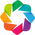

Successfully loaded MSO forecasts with 100 rows
Successfully loaded observed data with 1200 rows
Found 28 forecast files:
 - forecasts_lstm_h2_16_8_a0.1_b0.1_1943_2021.csv
 - forecasts_lstm_h2_32_16_a0.1_b0.1_1943_2021.csv
 - forecasts_lstm_h3_16_8_4_a0.1_b0.1_1943_2021.csv
 - forecasts_lstm_h3_32_16_8_a0.1_b0.1_1943_2021.csv
 - forecasts_lstm_h3_64_32_16_a0.1_b0.1_1943_2021.csv
 - forecasts_lstm_h3_8_4_2_a0.1_b0.1_1943_2021.csv
 - forecasts_all_years\forecasts_back_loaded_1923_2021.csv
 - forecasts_all_years\forecasts_bimodal_1923_2021.csv
 - forecasts_all_years\forecasts_current_amplified_1923_2021.csv
 - forecasts_all_years\forecasts_current_moderated_1923_2021.csv
 - forecasts_all_years\forecasts_current_standard_1923_2021.csv
 - forecasts_all_years\forecasts_front_loaded_1923_2021.csv
 - forecasts_all_years\forecasts_middle_emphasis_1923_2021.csv
 - forecasts_all_years\forecasts_spring_emphasis_1923_2021.csv
 - forecasts_all_years\forecasts_summer_emphasis_1923_2021.csv
 - forecas

In [3]:
import pandas as pd
import numpy as np
import panel as pn
import holoviews as hv
from sklearn.metrics import r2_score, mean_absolute_error
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, HoverTool, Legend
import matplotlib.pyplot as plt
import os
from glob import glob

# Enable extensions
hv.extension('bokeh')

# Define LSTM architectures for naming (updated to include [8, 4, 2])
lstm_architectures = [
    [64, 32, 16],  # Original architecture
    [32, 16, 8],   # Simpler 3-layer
    [16, 8, 4],    # Simpler 3-layer
    [8, 4, 2],     # Simpler 3-layer (added)
    [32, 16],      # 2-layer
    [16, 8],       # 2-layer
]

# Define the test/training cutoff years
TEST_START_YEAR = 1923
TEST_END_YEAR = 1942
TRAINING_START_YEAR = 1943

def get_model_name(architecture):
    """Generate consistent model name"""
    arch_str = f"h{len(architecture)}_" + "_".join(map(str, architecture))
    return f"lstm_{arch_str}_a0.1_b0.1_1943_2021"  # Updated to include 1943_2021 suffix

def find_forecast_files():
    """Find all available forecast CSV files"""
    forecast_files = glob("forecasts_*.csv") + glob("*/forecasts_*.csv")
    print(f"Found {len(forecast_files)} forecast files:")
    for file in forecast_files:
        print(f" - {file}")
    return forecast_files

def load_data():
    """Load all necessary data files"""
    # Status tracking for loaded data
    loaded_data = {
        "MSO": False,
        "Observed": False,
        "WYT": False,
        "Forecasts": 0
    }
    
    # Load MSO data
    try:
        mso_df = pd.read_csv('MSO_forecast_9.csv')
        print(f"Successfully loaded MSO forecasts with {len(mso_df)} rows")
        loaded_data["MSO"] = True
    except Exception as e:
        print(f"Error loading MSO forecasts: {str(e)}")
        print("Please make sure 'MSO_forecast_9.csv' exists and contains the expected columns.")
        mso_df = pd.DataFrame()  # Empty dataframe as fallback
    
    # Load observed data
    try:
        observed_df = pd.read_csv('Data/Clean/Orov_clean.csv')
        # Convert Date to datetime in observed data
        observed_df['Date'] = pd.to_datetime(observed_df['Date'])
        observed_df['Year'] = observed_df['Date'].dt.year
        observed_df['Month'] = observed_df['Date'].dt.month
        print(f"Successfully loaded observed data with {len(observed_df)} rows")
        loaded_data["Observed"] = True
    except Exception as e:
        print(f"Error loading observed data: {str(e)}")
        print("Please make sure 'Data/Clean/Orov_clean.csv' exists and contains the expected columns.")
        observed_df = pd.DataFrame(columns=['Date', 'Year', 'Month', 'F'])  # Empty dataframe as fallback
    
    # Load WYT data
    try:
        wyt_df = pd.read_csv('WYT.csv')
        wyt_df.columns = wyt_df.columns.str.strip().str.lower()  # Normalize column names
        if 'year' not in wyt_df.columns or 'wyt' not in wyt_df.columns:
            print("Warning: WYT file does not have expected columns. Looking for 'year' and 'wyt'")
            print(f"Available columns: {wyt_df.columns.tolist()}")
        else:
            loaded_data["WYT"] = True
    except Exception as e:
        print(f"Error loading WYT data: {str(e)}")
        wyt_df = pd.DataFrame(columns=['year', 'wyt'])
    
    # Find available forecast files
    available_forecasts = find_forecast_files()
    
    # Load all LSTM forecasts
    lstm_forecasts = {}
    
    # First try to load the files for the specified architectures
    for arch in lstm_architectures:
        model_name = get_model_name(arch)
        forecast_filename = f'forecasts_{model_name}.csv'
        
        # Check if file exists in current directory or any found files
        file_found = False
        for available_file in available_forecasts:
            if os.path.basename(available_file) == forecast_filename:
                forecast_filename = available_file
                file_found = True
                break
        
        if not file_found:
            print(f"Warning: Forecast file for {model_name} not found in the expected location.")
            continue
        
        try:
            df = pd.read_csv(forecast_filename)
            lstm_forecasts[model_name] = df
            loaded_data["Forecasts"] += 1
            print(f"Successfully loaded forecasts for {model_name}")
        except Exception as e:
            print(f"Error loading {forecast_filename}: {str(e)}")
    
    # If no forecasts were loaded using the architecture names, try to load any available forecast files
    if not lstm_forecasts and available_forecasts:
        print("\nAttempting to load any available forecast files...")
        for file_path in available_forecasts:
            try:
                # Extract model name from filename
                filename = os.path.basename(file_path)
                if filename.startswith('forecasts_') and filename.endswith('.csv'):
                    model_name = filename[len('forecasts_'):-4]  # Remove 'forecasts_' prefix and '.csv' suffix
                    
                    df = pd.read_csv(file_path)
                    lstm_forecasts[model_name] = df
                    loaded_data["Forecasts"] += 1
                    print(f"Successfully loaded forecasts for {model_name}")
            except Exception as e:
                print(f"Error loading {file_path}: {str(e)}")
    
    print(f"\nData loading summary:")
    print(f"MSO data: {'✓' if loaded_data['MSO'] else '✗'}")
    print(f"Observed data: {'✓' if loaded_data['Observed'] else '✗'}")
    print(f"WYT data: {'✓' if loaded_data['WYT'] else '✗'}")
    print(f"Forecast models: {loaded_data['Forecasts']}")
    
    return lstm_forecasts, mso_df, observed_df, wyt_df

def calculate_excel_r2(observed_values, forecast_values):
    """Calculate R-squared like Excel's CORREL^2"""
    try:
        if len(observed_values) != len(forecast_values):
            return None
            
        f_mean = np.mean(forecast_values)
        o_mean = np.mean(observed_values)
        
        numerator = sum((f - f_mean) * (o - o_mean) 
                        for f, o in zip(forecast_values, observed_values))
        
        f_variance = sum((f - f_mean) ** 2 for f in forecast_values)
        o_variance = sum((o - o_mean) ** 2 for o in observed_values)
        
        r = numerator / np.sqrt(f_variance * o_variance)
        return r ** 2
    except Exception as e:
        print(f"Error calculating Excel R2: {str(e)}")
        return None

def calculate_custom_loss(observed_values, forecast_values, alpha=0.1, beta=0.1):
    """Calculate the custom loss function with smoothness penalty and monthly weights"""
    try:
        month_weights = np.array([2, 2, 2, 1.5, 1.5, 1, 1, 1, 1])
        
        # MSE component
        mse_loss = np.mean((observed_values - forecast_values) ** 2)
        
        # Smoothness penalty
        smoothness_penalty = np.mean(np.square(forecast_values[1:] - forecast_values[:-1]))
        
        # Monthly weighted loss
        monthly_weight_loss = np.mean(month_weights * np.square(observed_values - forecast_values))
        
        return mse_loss + alpha * smoothness_penalty + beta * monthly_weight_loss
    except Exception as e:
        print(f"Error calculating custom loss: {str(e)}")
        return None

def calculate_percentage_bias(observed_values, forecast_values):
    """Calculate percentage bias"""
    try:
        return 100 * (np.mean(forecast_values) - np.mean(observed_values)) / np.mean(observed_values)
    except Exception as e:
        print(f"Error calculating percentage bias: {str(e)}")
        return None

def create_comparison_plot(lstm_forecasts, mso_df, observed_df, selected_year, wyt_value=None, is_training=None):
    """Create comparison plot with all models using direct Bokeh implementation"""
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep']
    month_nums = list(range(1, 10))
    
    # Check if required data is available
    if observed_df.empty:
        return pn.pane.Markdown(f"**Error:** Observed data not loaded. Cannot create plot for year {selected_year}.")
    
    # Create a Bokeh figure
    title = f'Flow Comparison for Year {selected_year}'
    if wyt_value:
        title += f' (WYT = {wyt_value})'
    
    # Add period indicator to title
    if is_training is not None:
        period_label = "Training Period" if is_training else "Test Period"
        title += f' - {period_label}'
    
    # Create the plot
    try:
        p = figure(
            width=900, 
            height=500,
            title=title,
            tools="pan,wheel_zoom,box_zoom,reset,save",
            x_range=[0.5, 9.5],  # Slightly expanded range for better visibility
            toolbar_location="above"
        )
        
        # Set background color based on period
        if is_training is not None:
            if is_training:
                p.background_fill_color = "#f5f5ff"  # Light blue for training
            else:
                p.background_fill_color = "#fff5f5"  # Light red for test
        
        # Set up x-axis ticks with month names
        p.xaxis.ticker = month_nums
        p.xaxis.major_label_overrides = {i: m for i, m in zip(month_nums, months)}
        
        # Create hover tool
        hover = HoverTool(
            tooltips=[
                ("Series", "$name"),
                ("Month", "@month"),
                ("Value", "@value{0.0}")
            ],
            line_policy='nearest',
            point_policy='snap_to_data',
            mode='mouse'
        )
        p.add_tools(hover)
        
        legend_items = []
        
        # Add MSO forecast if available
        if not mso_df.empty and selected_year in mso_df['Year'].values:
            try:
                mso_forecast = mso_df[mso_df['Year'] == selected_year].iloc[0]
                mso_values = [float(mso_forecast[month]) for month in months]
                
                # Create MSO data source
                source_mso = ColumnDataSource(data=dict(
                    x=month_nums,
                    value=mso_values,
                    month=months
                ))
                
                # Create MSO line
                r_mso = p.line('x', 'value', source=source_mso, 
                              line_width=2, color='green', line_dash='dotted')
                r_mso.name = "MSO"  # Set name for hover tool
                
                # Add to legend
                legend_items.append(("MSO", [r_mso]))
            except Exception as e:
                print(f"Error adding MSO forecast for year {selected_year}: {str(e)}")
        
        # Get observed data for selected year
        observed_data = observed_df[
            (observed_df['Year'] == selected_year) & 
            (observed_df['Month'].isin(range(1, 10)))
        ]
        
        # Add observed data if available
        if not observed_data.empty:
            try:
                # Prepare observed values (handle missing months)
                observed_values = []
                for m in month_nums:
                    month_data = observed_data[observed_data['Month'] == m]
                    if not month_data.empty:
                        observed_values.append(float(month_data['F'].values[0]))
                    else:
                        observed_values.append(float('nan'))
                
                # Create observed data source
                source_obs = ColumnDataSource(data=dict(
                    x=month_nums,
                    value=observed_values,
                    month=months
                ))
                
                # Create observed line
                r_obs = p.line('x', 'value', source=source_obs, 
                              line_width=3, color='red')
                r_obs.name = "Observed"  # Set name for hover tool
                
                # Add to legend
                legend_items.append(("Observed", [r_obs]))
            except Exception as e:
                print(f"Error adding observed data for year {selected_year}: {str(e)}")
        
        # Add LSTM models
        if lstm_forecasts:
            colors = plt.cm.rainbow(np.linspace(0, 1, len(lstm_forecasts)))
            
            for (model_name, lstm_df), color in zip(lstm_forecasts.items(), colors):
                try:
                    if selected_year not in lstm_df['Year'].values:
                        print(f"Warning: Year {selected_year} not found in {model_name} forecasts")
                        continue
                        
                    lstm_forecast = lstm_df[lstm_df['Year'] == selected_year].iloc[0]
                    
                    # Check if F_month columns exist
                    f_columns = [f'F_{month}' for month in months]
                    missing_columns = [col for col in f_columns if col not in lstm_forecast.index]
                    if missing_columns:
                        print(f"Warning: {model_name} is missing columns: {missing_columns}")
                        continue
                        
                    lstm_values = [float(lstm_forecast[f'F_{m}']) for m in months]
                    
                    # Create LSTM data source
                    source_lstm = ColumnDataSource(data=dict(
                        x=month_nums,
                        value=lstm_values,
                        month=months
                    ))
                    
                    # Create LSTM line with unique color
                    hex_color = rgb_to_hex(color)
                    r_lstm = p.line('x', 'value', source=source_lstm, 
                                  line_width=2, color=hex_color, line_dash='dashed')
                    r_lstm.name = model_name  # Set name for hover tool
                    
                    # Add to legend
                    legend_items.append((model_name, [r_lstm]))
                except Exception as e:
                    print(f"Error adding {model_name} for year {selected_year}: {str(e)}")
        
        # Add legend if we have any items
        if legend_items:
            legend = Legend(items=legend_items)
            legend.click_policy = "hide"  # Allow toggling lines by clicking legend
            p.add_layout(legend, 'right')
        
        # Format the plot
        p.grid.grid_line_alpha = 0.3
        p.y_range.start = 0  # Start y-axis at 0
        p.yaxis.axis_label = "Flow"
        p.xaxis.axis_label = "Month"
        
        # Create a Panel pane from the Bokeh figure
        return pn.pane.Bokeh(p)
        
    except Exception as e:
        error_message = f"Error creating plot for year {selected_year}: {str(e)}"
        print(error_message)
        return pn.pane.Markdown(f"**Error:** {error_message}")

def calculate_all_metrics(lstm_forecasts, mso_df, observed_df, selected_year):
    """Calculate all metrics for each model"""
    try:
        months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep']
        metrics_text = []
        
        # Check if observed data is available
        observed_data = observed_df[
            (observed_df['Year'] == selected_year) & 
            (observed_df['Month'].isin(range(1, 10)))
        ]
        
        if observed_data.empty:
            return "**Metrics:** No observed data available for this year."
        
        observed_values = np.array(observed_data['F'].values)
        
        # Check if we have complete data (9 months)
        if len(observed_values) != 9:
            return f"**Metrics:** Incomplete observed data for this year ({len(observed_values)}/9 months)."
        
        # Calculate MSO metrics if available
        if not mso_df.empty and selected_year in mso_df['Year'].values:
            try:
                mso_forecast = mso_df[mso_df['Year'] == selected_year].iloc[0]
                mso_values = np.array([float(mso_forecast[month]) for month in months])
                
                mso_metrics = {
                    'Excel R²': calculate_excel_r2(observed_values, mso_values),
                    'Sklearn R²': r2_score(observed_values, mso_values),
                    'MAE': mean_absolute_error(observed_values, mso_values),
                    'Custom Loss': calculate_custom_loss(observed_values, mso_values),
                    'Percentage Bias': calculate_percentage_bias(observed_values, mso_values)
                }
                
                # Filter out None values
                mso_metrics = {k: v for k, v in mso_metrics.items() if v is not None}
                
                if mso_metrics:
                    metrics_text.append("**MSO Metrics:**\n" + 
                                       " | ".join([f"{k}: {v:.2f}" for k, v in mso_metrics.items()]))
                else:
                    metrics_text.append("**MSO Metrics:** Error calculating metrics.")
            except Exception as e:
                metrics_text.append(f"**MSO Metrics:** Error: {str(e)}")
        
        # Calculate LSTM metrics
        for model_name, lstm_df in lstm_forecasts.items():
            try:
                # Skip if this year doesn't exist in the forecast data
                if selected_year not in lstm_df['Year'].values:
                    metrics_text.append(f"**{model_name} Metrics:** No forecast available for this year.")
                    continue
                
                lstm_forecast = lstm_df[lstm_df['Year'] == selected_year].iloc[0]
                
                # Check if F_month columns exist
                f_columns = [f'F_{month}' for month in months]
                if not all(col in lstm_forecast.index for col in f_columns):
                    metrics_text.append(f"**{model_name} Metrics:** Incomplete forecast data for this year.")
                    continue
                
                lstm_values = np.array([float(lstm_forecast[f'F_{month}']) for month in months])
                
                model_metrics = {
                    'Excel R²': calculate_excel_r2(observed_values, lstm_values),
                    'Sklearn R²': r2_score(observed_values, lstm_values),
                    'MAE': mean_absolute_error(observed_values, lstm_values),
                    'Custom Loss': calculate_custom_loss(observed_values, lstm_values),
                    'Percentage Bias': calculate_percentage_bias(observed_values, lstm_values)
                }
                
                # Filter out None values
                model_metrics = {k: v for k, v in model_metrics.items() if v is not None}
                
                if model_metrics:
                    metrics_text.append(f"**{model_name} Metrics:**\n" + 
                                      " | ".join([f"{k}: {v:.2f}" for k, v in model_metrics.items()]))
                else:
                    metrics_text.append(f"**{model_name} Metrics:** Error calculating metrics.")
            except Exception as e:
                metrics_text.append(f"**{model_name} Metrics:** Error: {str(e)}")
        
        return "\n\n".join(metrics_text)
    except Exception as e:
        print(f"Detailed error calculating metrics: {str(e)}")
        return f"**Metrics:** Error calculating metrics: {str(e)}"

def rgb_to_hex(rgba_color):
    """Convert RGB(A) color to hex"""
    try:
        rgb = tuple(int(x * 255) for x in rgba_color[:3])
        return '#{:02x}{:02x}{:02x}'.format(*rgb)
    except Exception as e:
        print(f"Error converting color: {str(e)}")
        return '#000000'  # Default to black on error

def get_common_years(lstm_forecasts, mso_df, observed_df):
    """Get years common to all datasets, with fallbacks for missing data"""
    try:
        # Start with all years from observed data
        if not observed_df.empty and 'Year' in observed_df.columns:
            all_years = set(observed_df['Year'].unique())
        else:
            # Fallback to years 1921-2021 if no observed data
            all_years = set(range(1921, 2022))
        
        # Intersect with MSO years if available
        if not mso_df.empty and 'Year' in mso_df.columns:
            mso_years = set(mso_df['Year'])
            all_years = all_years.intersection(mso_years)
        
        # Intersect with LSTM years if available
        if lstm_forecasts:
            for model_name, df in lstm_forecasts.items():
                if 'Year' in df.columns:
                    model_years = set(df['Year'].unique())
                    all_years = all_years.intersection(model_years)
        
        # Sort years for display
        return sorted(list(all_years))
    except Exception as e:
        print(f"Error getting common years: {str(e)}")
        # Fallback to limited year range if error occurs
        return list(range(1923, 2022))

def is_test_year(year):
    """Check if a year is in the test period (1923-1942)"""
    return TEST_START_YEAR <= year <= TEST_END_YEAR

def create_dashboard():
    """Create the main dashboard"""
    # Load data
    lstm_forecasts, mso_df, observed_df, wyt_df = load_data()
    
    # Create containers
    plots_container = pn.Column()
    
    # Get common years across all models (with error handling)
    years = get_common_years(lstm_forecasts, mso_df, observed_df)
    
    # Inform if no years found
    if not years:
        plots_container.append(pn.pane.Markdown("**Error:** No common years found across datasets."))
        years = list(range(1923, 2022))  # Fallback for UI to work
    
    # Split years into training and test sets
    test_years = [y for y in years if is_test_year(y)]
    training_years = [y for y in years if y >= TRAINING_START_YEAR]
    
    # Prepare water year type options
    wyt_options = ['C', 'D', 'BN', 'AN', 'W']
    if not wyt_df.empty and 'wyt' in wyt_df.columns:
        available_wyt = sorted(wyt_df['wyt'].unique())
        if len(available_wyt) > 0:
            wyt_options = available_wyt
    
    # Create period selector
    period_select = pn.widgets.RadioButtonGroup(
        name='Dataset Period',
        options=['All', 'Training', 'Test'],
        value='All',
        button_type='success'
    )
    
    # Create water year type selector
    wyt_select = pn.widgets.MultiChoice(
        name='Select Water Year Types',
        options=wyt_options,
        value=[],
        height=100
    )
    
    # Create year selector (will be updated based on WYT and period selection)
    year_select = pn.widgets.MultiChoice(
        name='Select Years',
        options=list(map(str, years)),
        value=[str(years[-1])] if years else [],
        height=300
    )
    
    # Create data status indicator (without style parameter)
    data_status_text = f"""
    ### Data Status:
    - **Observed Data:** {'✓ Loaded' if not observed_df.empty else '✗ Missing'}
    - **MSO Forecasts:** {'✓ Loaded' if not mso_df.empty else '✗ Missing'}
    - **WYT Data:** {'✓ Loaded' if not wyt_df.empty else '✗ Missing'}
    - **LSTM Models:** {'✓ Loaded ' + str(len(lstm_forecasts)) + ' models' if lstm_forecasts else '✗ Missing'}
    """
    data_status = pn.pane.Markdown(data_status_text)
    
    def update_year_options(event):
        # Get selected period
        selected_period = period_select.value
        
        # Filter years based on period
        if selected_period == 'Training':
            period_filtered_years = training_years
        elif selected_period == 'Test':
            period_filtered_years = test_years
        else:  # 'All'
            period_filtered_years = years
        
        # Filter years based on selected water year types
        selected_wyt = wyt_select.value
        
        if not selected_wyt or wyt_df.empty or 'wyt' not in wyt_df.columns:
            # If no WYT selected or no WYT data, show all years for the selected period
            filtered_years = period_filtered_years
        else:
            try:
                # Filter years by selected WYT
                wyt_filtered_years = wyt_df[wyt_df['wyt'].isin(selected_wyt)]['year'].astype(int).tolist()
                # Only keep years that exist in our dataset and the selected period
                filtered_years = sorted(list(set(wyt_filtered_years).intersection(set(period_filtered_years))))
            except Exception as e:
                print(f"Error filtering years by WYT: {str(e)}")
                filtered_years = period_filtered_years
        
        # Update year selector options
        year_select.options = list(map(str, filtered_years))
        
        # If current selection is not in filtered options, select the most recent year
        if not set(year_select.value).intersection(set(year_select.options)) and year_select.options:
            year_select.value = [year_select.options[-1]]
        elif not year_select.options:
            year_select.value = []
    
    def update_plots(event):
        # Clear the container
        plots_container.clear()
        
        # Add warning if data is missing
        if observed_df.empty:
            plots_container.append(pn.pane.Markdown("⚠️ **Warning:** Observed data is missing. Plots may not display correctly."))
        
        if not lstm_forecasts:
            plots_container.append(pn.pane.Markdown("⚠️ **Warning:** No forecast models were found. Please run the forecast generation code first."))
        
        # Get selected period for visual indication
        selected_period = period_select.value
        
        # Handle no years selected
        if not year_select.value:
            plots_container.append(pn.pane.Markdown("**No years selected.** Please select at least one year to display."))
            return
        
        # Create plots for each selected year
        for year_str in year_select.value:
            try:
                year = int(year_str)
                
                # Determine if this year is in training or test set
                is_training = None
                if selected_period != 'All':
                    is_training = not is_test_year(year)  # Year is in training set if not in test period
                
                # Get WYT for this year if available
                wyt_value = None
                if not wyt_df.empty and 'year' in wyt_df.columns and 'wyt' in wyt_df.columns:
                    year_wyt = wyt_df[wyt_df['year'] == year]['wyt'].values
                    if len(year_wyt) > 0:
                        wyt_value = year_wyt[0]
                
                # Create plot with WYT in title if available
                plot = create_comparison_plot(lstm_forecasts, mso_df, observed_df, year, wyt_value, is_training)
                
                # Calculate metrics
                metrics_text = calculate_all_metrics(lstm_forecasts, mso_df, observed_df, year)
                
                # Create period indicator without style parameter
                if selected_period != 'All':
                    period_indicator = "## <span style='color:blue;'>Training Period (≥ 1943)</span>" if is_training else "## <span style='color:red;'>Test Period (1923-1942)</span>"
                else:
                    period_indicator = "## <span style='color:blue;'>Training Period (≥ 1943)</span>" if year >= TRAINING_START_YEAR else "## <span style='color:red;'>Test Period (1923-1942)</span>"
                
                # Add to container (using HTML in Markdown instead of style parameter)
                plots_container.extend([
                    pn.pane.Markdown(period_indicator),
                    plot,
                    pn.pane.Markdown(metrics_text),
                    pn.layout.Divider()
                ])
            except Exception as e:
                plots_container.append(pn.pane.Markdown(f"**Error creating plot for year {year_str}:** {str(e)}"))
    
    # Set up the callbacks
    period_select.param.watch(update_year_options, 'value')
    wyt_select.param.watch(update_year_options, 'value')
    year_select.param.watch(update_plots, 'value')
    
    # Initial update
    update_year_options(None)
    update_plots(None)
    
    # Create period stats pane to show counts (without style parameter)
    period_stats_text = f"""
    ### Dataset Period Counts:
    - **Training Period (≥ 1943):** {len(training_years)} years
    - **Test Period (1923-1942):** {len(test_years)} years
    - **Total:** {len(years)} years
    """
    period_stats_pane = pn.pane.Markdown(period_stats_text)
    
    # Create layout
    dashboard = pn.Column(
        "## Flow Forecast Comparison",
        pn.Row(
            pn.Column(
                "### Select Dataset Period", 
                period_select,
                period_stats_pane,
                data_status,
                "### Select Water Year Types", 
                wyt_select,
                "### Select Years", 
                year_select, 
                width=300
            ),
            plots_container
        )
    )
    
    return dashboard

if __name__ == "__main__":
    # Create and display the dashboard
    dashboard = create_dashboard()
    pn.serve(dashboard)

In [7]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error
import os
from glob import glob
import matplotlib.pyplot as plt

# Define constants
TEST_START_YEAR = 1923
TEST_END_YEAR = 1942
TRAINING_START_YEAR = 1943

# Define LSTM architectures for naming (updated to include [8, 4, 2])
lstm_architectures = [
    [64, 32, 16],  # Original architecture
    [32, 16, 8],   # Simpler 3-layer
    [16, 8, 4],    # Simpler 3-layer
    [8, 4, 2],     # Simpler 3-layer (added)
    [32, 16],      # 2-layer
    [16, 8],       # 2-layer
]

def get_model_name(architecture):
    """Generate consistent model name"""
    arch_str = f"h{len(architecture)}_" + "_".join(map(str, architecture))
    return f"lstm_{arch_str}_a0.1_b0.1_1943_2021"

def find_forecast_files():
    """Find all available forecast CSV files"""
    forecast_files = glob("forecasts_*.csv") + glob("*/forecasts_*.csv")
    print(f"Found {len(forecast_files)} forecast files:")
    for file in forecast_files:
        print(f" - {file}")
    return forecast_files

def is_test_year(year):
    """Check if a year is in the test period (1923-1942)"""
    return TEST_START_YEAR <= year <= TEST_END_YEAR

def load_data():
    """Load all necessary data files"""
    # Status tracking for loaded data
    data_files = {
        "MSO": None,
        "Observed": None,
        "WYT": None,
        "Forecasts": {}
    }
    
    # Load MSO data
    try:
        mso_df = pd.read_csv('MSO_forecast_9.csv')
        print(f"Successfully loaded MSO forecasts with {len(mso_df)} rows")
        data_files["MSO"] = mso_df
    except Exception as e:
        print(f"Error loading MSO forecasts: {str(e)}")
        print("Please make sure 'MSO_forecast_9.csv' exists and contains the expected columns.")
        data_files["MSO"] = pd.DataFrame()  # Empty dataframe as fallback
    
    # Load observed data
    try:
        observed_df = pd.read_csv('Data/Clean/Orov_clean.csv')
        # Convert Date to datetime in observed data
        observed_df['Date'] = pd.to_datetime(observed_df['Date'])
        observed_df['Year'] = observed_df['Date'].dt.year
        observed_df['Month'] = observed_df['Date'].dt.month
        print(f"Successfully loaded observed data with {len(observed_df)} rows")
        data_files["Observed"] = observed_df
    except Exception as e:
        print(f"Error loading observed data: {str(e)}")
        print("Please make sure 'Data/Clean/Orov_clean.csv' exists and contains the expected columns.")
        data_files["Observed"] = pd.DataFrame(columns=['Date', 'Year', 'Month', 'F'])
    
    # Load WYT data
    try:
        wyt_df = pd.read_csv('WYT.csv')
        wyt_df.columns = wyt_df.columns.str.strip().str.lower()  # Normalize column names
        if 'year' not in wyt_df.columns or 'wyt' not in wyt_df.columns:
            print("Warning: WYT file does not have expected columns. Looking for 'year' and 'wyt'")
            print(f"Available columns: {wyt_df.columns.tolist()}")
            data_files["WYT"] = pd.DataFrame(columns=['year', 'wyt'])
        else:
            data_files["WYT"] = wyt_df
    except Exception as e:
        print(f"Error loading WYT data: {str(e)}")
        data_files["WYT"] = pd.DataFrame(columns=['year', 'wyt'])
    
    # Find available forecast files
    available_forecasts = find_forecast_files()
    
    # Load all LSTM forecasts
    lstm_forecasts = {}
    
    # First try to load the files for the specified architectures
    for arch in lstm_architectures:
        model_name = get_model_name(arch)
        forecast_filename = f'forecasts_{model_name}.csv'
        
        # Check if file exists in current directory or any found files
        file_found = False
        for available_file in available_forecasts:
            if os.path.basename(available_file) == forecast_filename:
                forecast_filename = available_file
                file_found = True
                break
        
        if not file_found:
            print(f"Warning: Forecast file for {model_name} not found in the expected location.")
            continue
        
        try:
            df = pd.read_csv(forecast_filename)
            lstm_forecasts[model_name] = df
            print(f"Successfully loaded forecasts for {model_name}")
        except Exception as e:
            print(f"Error loading {forecast_filename}: {str(e)}")
    
    # If no forecasts were loaded using the architecture names, try to load any available forecast files
    if not lstm_forecasts and available_forecasts:
        print("\nAttempting to load any available forecast files...")
        for file_path in available_forecasts:
            try:
                # Extract model name from filename
                filename = os.path.basename(file_path)
                if filename.startswith('forecasts_') and filename.endswith('.csv'):
                    model_name = filename[len('forecasts_'):-4]  # Remove 'forecasts_' prefix and '.csv' suffix
                    
                    df = pd.read_csv(file_path)
                    lstm_forecasts[model_name] = df
                    print(f"Successfully loaded forecasts for {model_name}")
            except Exception as e:
                print(f"Error loading {file_path}: {str(e)}")
    
    data_files["Forecasts"] = lstm_forecasts
    
    print(f"\nData loading summary:")
    print(f"MSO data: {'✓ Loaded' if not data_files['MSO'].empty else '✗ Missing'}")
    print(f"Observed data: {'✓ Loaded' if not data_files['Observed'].empty else '✗ Missing'}")
    print(f"WYT data: {'✓ Loaded' if not data_files['WYT'].empty else '✗ Missing'}")
    print(f"Forecast models: {len(data_files['Forecasts'])}")
    
    return data_files

def calculate_excel_r2(observed_values, forecast_values):
    """Calculate R-squared like Excel's CORREL^2"""
    try:
        if len(observed_values) != len(forecast_values):
            return None
            
        f_mean = np.mean(forecast_values)
        o_mean = np.mean(observed_values)
        
        numerator = sum((f - f_mean) * (o - o_mean) 
                        for f, o in zip(forecast_values, observed_values))
        
        f_variance = sum((f - f_mean) ** 2 for f in forecast_values)
        o_variance = sum((o - o_mean) ** 2 for o in observed_values)
        
        r = numerator / np.sqrt(f_variance * o_variance)
        return r ** 2
    except Exception as e:
        print(f"Error calculating Excel R2: {str(e)}")
        return None

def calculate_custom_loss(observed_values, forecast_values, alpha=0.1, beta=0.1):
    """Calculate the custom loss function with smoothness penalty and monthly weights"""
    try:
        month_weights = np.array([2, 2, 2, 1.5, 1.5, 1, 1, 1, 1])
        
        # MSE component
        mse_loss = np.mean((observed_values - forecast_values) ** 2)
        
        # Smoothness penalty
        smoothness_penalty = np.mean(np.square(forecast_values[1:] - forecast_values[:-1]))
        
        # Monthly weighted loss
        monthly_weight_loss = np.mean(month_weights * np.square(observed_values - forecast_values))
        
        return mse_loss + alpha * smoothness_penalty + beta * monthly_weight_loss
    except Exception as e:
        print(f"Error calculating custom loss: {str(e)}")
        return None

def calculate_percentage_bias(observed_values, forecast_values):
    """Calculate percentage bias"""
    try:
        return 100 * (np.mean(forecast_values) - np.mean(observed_values)) / np.mean(observed_values)
    except Exception as e:
        print(f"Error calculating percentage bias: {str(e)}")
        return None

def calculate_metrics_for_all_years(data_files):
    """Calculate metrics for all years and all models"""
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep']
    
    # Extract data
    observed_df = data_files["Observed"]
    mso_df = data_files["MSO"]
    wyt_df = data_files["WYT"]
    lstm_forecasts = data_files["Forecasts"]
    
    # Get all available years from observed data
    if observed_df.empty:
        print("Error: Observed data is missing. Cannot calculate metrics.")
        return pd.DataFrame()
    
    all_years = sorted(observed_df['Year'].unique())
    
    # Create a list to store all metrics rows
    all_metrics = []
    
    # Process each year
    for year in all_years:
        # Check if year has observed data for all 9 months
        observed_data = observed_df[
            (observed_df['Year'] == year) & 
            (observed_df['Month'].isin(range(1, 10)))
        ]
        
        if len(observed_data) != 9:
            print(f"Skipping year {year}: Incomplete observed data ({len(observed_data)}/9 months)")
            continue
        
        # Get observed values for this year
        observed_values = observed_data['F'].values
        
        # Get WYT for this year
        wyt_value = "Unknown"
        if not wyt_df.empty and 'year' in wyt_df.columns and 'wyt' in wyt_df.columns:
            year_wyt = wyt_df[wyt_df['year'] == year]['wyt'].values
            if len(year_wyt) > 0:
                wyt_value = year_wyt[0]
        
        # Determine if year is in training or test set
        is_training = not is_test_year(year)
        period_label = "Training" if is_training else "Test"
        
        # Process MSO forecast if available
        if not mso_df.empty and year in mso_df['Year'].values:
            mso_forecast = mso_df[mso_df['Year'] == year].iloc[0]
            
            try:
                mso_values = np.array([float(mso_forecast[month]) for month in months])
                
                # Calculate metrics
                excel_r2 = calculate_excel_r2(observed_values, mso_values)
                sklearn_r2 = r2_score(observed_values, mso_values)
                mae = mean_absolute_error(observed_values, mso_values)
                custom_loss = calculate_custom_loss(observed_values, mso_values)
                percent_bias = calculate_percentage_bias(observed_values, mso_values)
                
                # Add to metrics list
                all_metrics.append({
                    'Year': year,
                    'Model': 'MSO',
                    'Period': period_label,
                    'WYT': wyt_value,
                    'Excel_R2': excel_r2,
                    'Sklearn_R2': sklearn_r2,
                    'MAE': mae,
                    'Custom_Loss': custom_loss,
                    'Percent_Bias': percent_bias
                })
            except Exception as e:
                print(f"Error calculating MSO metrics for year {year}: {str(e)}")
        
        # Process each LSTM model
        for model_name, lstm_df in lstm_forecasts.items():
            if year not in lstm_df['Year'].values:
                continue
                
            lstm_forecast = lstm_df[lstm_df['Year'] == year].iloc[0]
            
            # Check if F_month columns exist
            f_columns = [f'F_{month}' for month in months]
            if not all(col in lstm_forecast.index for col in f_columns):
                print(f"Skipping {model_name} for year {year}: Incomplete forecast data")
                continue
            
            try:
                lstm_values = np.array([float(lstm_forecast[f'F_{month}']) for month in months])
                
                # Calculate metrics
                excel_r2 = calculate_excel_r2(observed_values, lstm_values)
                sklearn_r2 = r2_score(observed_values, lstm_values)
                mae = mean_absolute_error(observed_values, lstm_values)
                custom_loss = calculate_custom_loss(observed_values, lstm_values)
                percent_bias = calculate_percentage_bias(observed_values, lstm_values)
                
                # Add to metrics list
                all_metrics.append({
                    'Year': year,
                    'Model': model_name,
                    'Period': period_label,
                    'WYT': wyt_value,
                    'Excel_R2': excel_r2,
                    'Sklearn_R2': sklearn_r2,
                    'MAE': mae,
                    'Custom_Loss': custom_loss,
                    'Percent_Bias': percent_bias
                })
            except Exception as e:
                print(f"Error calculating {model_name} metrics for year {year}: {str(e)}")
    
    # Convert to DataFrame
    metrics_df = pd.DataFrame(all_metrics)
    
    return metrics_df

def main():
    print("Loading data files...")
    data_files = load_data()
    
    print("\nCalculating metrics for all years and models...")
    metrics_df = calculate_metrics_for_all_years(data_files)
    
    if metrics_df.empty:
        print("Error: No metrics were calculated. Check that data files are available.")
        return
    
    print(f"Successfully calculated metrics for {len(metrics_df)} year/model combinations")
    
    # Save to CSV
    output_file = 'all_metrics_summary.csv'
    metrics_df.to_csv(output_file, index=False)
    print(f"Metrics saved to {output_file}")
    
    # Generate summary statistics by model and period
    try:
        # Group by Model and Period
        summary = metrics_df.groupby(['Model', 'Period']).agg({
            'Excel_R2': ['mean', 'std', 'min', 'max'],
            'Sklearn_R2': ['mean', 'std', 'min', 'max'],
            'MAE': ['mean', 'std', 'min', 'max'],
            'Custom_Loss': ['mean', 'std', 'min', 'max'],
            'Percent_Bias': ['mean', 'std', 'min', 'max']
        }).reset_index()
        
        # Flatten multi-level columns
        summary.columns = ['_'.join(col).strip('_') for col in summary.columns.values]
        
        summary_file = 'metrics_summary_by_model_period.csv'
        summary.to_csv(summary_file, index=False)
        print(f"Summary statistics saved to {summary_file}")
        
        # Generate additional summary by Water Year Type
        wyt_summary = metrics_df.groupby(['Model', 'WYT']).agg({
            'Excel_R2': ['mean', 'std'],
            'MAE': ['mean', 'std'],
            'Custom_Loss': ['mean', 'std']
        }).reset_index()
        
        # Flatten multi-level columns
        wyt_summary.columns = ['_'.join(col).strip('_') for col in wyt_summary.columns.values]
        
        wyt_summary_file = 'metrics_summary_by_wyt.csv'
        wyt_summary.to_csv(wyt_summary_file, index=False)
        print(f"WYT summary statistics saved to {wyt_summary_file}")
        
    except Exception as e:
        print(f"Error generating summary statistics: {str(e)}")

if __name__ == "__main__":
    main()

Loading data files...
Successfully loaded MSO forecasts with 100 rows
Successfully loaded observed data with 1200 rows
Found 6 forecast files:
 - forecasts_lstm_h2_16_8_a0.1_b0.1_1943_2021.csv
 - forecasts_lstm_h2_32_16_a0.1_b0.1_1943_2021.csv
 - forecasts_lstm_h3_16_8_4_a0.1_b0.1_1943_2021.csv
 - forecasts_lstm_h3_32_16_8_a0.1_b0.1_1943_2021.csv
 - forecasts_lstm_h3_64_32_16_a0.1_b0.1_1943_2021.csv
 - forecasts_lstm_h3_8_4_2_a0.1_b0.1_1943_2021.csv
Successfully loaded forecasts for lstm_h3_64_32_16_a0.1_b0.1_1943_2021
Successfully loaded forecasts for lstm_h3_32_16_8_a0.1_b0.1_1943_2021
Successfully loaded forecasts for lstm_h3_16_8_4_a0.1_b0.1_1943_2021
Successfully loaded forecasts for lstm_h3_8_4_2_a0.1_b0.1_1943_2021
Successfully loaded forecasts for lstm_h2_32_16_a0.1_b0.1_1943_2021
Successfully loaded forecasts for lstm_h2_16_8_a0.1_b0.1_1943_2021

Data loading summary:
MSO data: ✓ Loaded
Observed data: ✓ Loaded
WYT data: ✓ Loaded
Forecast models: 6

Calculating metrics for all 